<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Scatter-plots" data-toc-modified-id="Scatter-plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scatter plots</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regression</a></span></li></ul></div>

## Data cleaning

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind_from_stats, pearsonr
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import re

In [2]:
# get files, clean them up
def clean_files(df, control):
    file = pd.read_csv(df, index_col = 0)
    file.index = file.index.str.strip()
    if not (control):
        file = file[["2017", "2018", "2019", "2020", "2021"]]
    return file
    
violent_crime = clean_files("data_files/violent_crime_rates.csv", control=False)
property_crime = clean_files("data_files/property_crime_rates.csv", control=False)
unemployment = clean_files("data_files/unemployment.csv", control=False)
health_factors = clean_files("data_files/health_factors.csv", control=False)
health_outcomes = clean_files("data_files/health_outcomes.csv", control=False)
od_deaths = clean_files("data_files/od_death_rate_final.csv", control=False)
free_reduced_meals = clean_files("data_files/free_reduced_meals.csv", control=False)
graduation_rates = clean_files("data_files/graduation_rates.csv", control=False)
population = clean_files("data_files/population.csv", control=False)
wealth_metrics = clean_files("data_files/wealth_metrics.csv", control=True)
urban_rural = clean_files("data_files/urban_rural.csv", control=True)
political_affiliation = clean_files("data_files/political_affiliation.csv", control=True)

In [3]:
# remove commas from data
def remove_commas(string):
    return re.sub(",", "", string)

for col in population.columns:
    population.loc[:,col] = population[col].astype(str).apply(remove_commas).astype(int)
    
# remove percentage signs from data
def remove_percentage(string):
    return re.sub("%", "", string)

for col in free_reduced_meals.columns:
    free_reduced_meals.loc[:,col] = free_reduced_meals[col].astype(str).apply(remove_percentage).astype(float)
    
def remove_dollar(string):
    return re.sub("\$", "", string)

for col in wealth_metrics.columns:
    wealth_metrics.loc[:,col] = wealth_metrics[col].astype(str).apply(remove_dollar)
    wealth_metrics.loc[:,col] = wealth_metrics[col].astype(str).apply(remove_commas)
    

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_59874/3877520494.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  population.loc[:,col] = population[col].astype(str).apply(remove_commas).astype(int)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_59874/3877520494.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  free_reduced_meals.loc[:,col] = free_reduced_meals[col].astype(str).apply(remove_percentage).astype(float)


In [4]:
def res_to_df(res):
    """
    Transform the result of an statsmodels results table to
    a pandas dataframe"""
    pvals = res.pvalues
    coeff = res.params
    conf_lower = res.conf_int()[0]
    conf_higher = res.conf_int()[1]
    df = pd.DataFrame(
        {
            "pvals": pvals,
            "coeff": coeff,
            "conf_lower": conf_lower,
            "conf_higher": conf_higher,
        }
    )
    cols = ["coeff", "pvals", "conf_lower", "conf_higher"]
    df = df[cols]
    df.reset_index(inplace=True)
    df.columns = ["name"] + cols
    return df

In [5]:
# convert crime rates from numbers to per capita
violent_crime.astype(int)
per_capita_crime = violent_crime / population

property_crime.astype(int)
per_capita_property_crime = property_crime / population

urban_rural.columns = ['total_units', 'urban_units', 'rural_units']

urban_rural.urban_units = urban_rural.urban_units / urban_rural.total_units
urban_rural.rural_units = urban_rural.rural_units / urban_rural.total_units


In [6]:
wealth_metrics.columns = ['population', 'population_density', 'per_capita_income', 'median_household_income', 'median_family_income']
median_household_income = wealth_metrics.drop(['population', 'population_density', 'per_capita_income', 'median_family_income'], axis=1)
percent_urban = urban_rural.drop(['total_units', 'rural_units'], axis=1)

republican = political_affiliation.drop(["District Attorney (2022)", "Attorney General (2022)", "AG % Margin of Victory (2022)"], axis=1)


In [7]:
# unstack all the dataframes and rename their columns
population_all = population.unstack().reset_index()
per_capita_violent_all = per_capita_crime.unstack().reset_index()
per_capita_property_all = per_capita_property_crime.unstack().reset_index()
unemployment_all = unemployment.unstack().reset_index()
health_factors_all = health_factors.unstack().reset_index()
health_outcomes_all = health_outcomes.unstack().reset_index()
od_deaths_all = od_deaths.unstack().reset_index()
free_reduced_meals_all = free_reduced_meals.unstack().reset_index()
graduation_rates_all = graduation_rates.unstack().reset_index()

population_all.columns = ['year', 'county', 'population']
per_capita_violent_all.columns = ['year', 'county', 'violent_crime_rate']
per_capita_property_all.columns = ['year', 'county', 'property_crime_rate']
unemployment_all.columns = ['year', 'county', 'unemployment']
health_factors_all.columns = ['year', 'county', 'health_factors']
health_outcomes_all.columns = ['year', 'county', 'health_outcomes']
od_deaths_all.columns = ['year', 'county', 'od_deaths']
free_reduced_meals_all.columns = ['year', 'county', 'free_reduced_meals']
graduation_rates_all.columns = ['year', 'county', 'graduation_rate']

def combine_dfs(df_list):
    main_df = per_capita_violent_all
    for df in df_list:
        main_df = pd.merge(main_df, df)
    return main_df

clean_data = combine_dfs([population_all, per_capita_property_all, unemployment_all, health_factors_all, 
                          health_outcomes_all, od_deaths_all, graduation_rates_all, free_reduced_meals_all])


## Scatter plots

In [31]:
def plot_rates(x, y, title, xlabel, ylabel, color):
    plt.scatter(x, y, color=f'{color}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [32]:
clean_data["median_household_income"] = clean_data.county.map(median_household_income.iloc[:,0])
clean_data["percent_urban"] = clean_data.county.map(percent_urban.iloc[:,0])
clean_data["republican"] = clean_data.county.map(republican.iloc[:,0])

In [53]:
clean_data

,year,county,violent_crime_rate,population,property_crime_rate,unemployment,health_factors,health_outcomes,od_deaths,graduation_rate,free_reduced_meals,median_household_income,percent_urban,republican
0,2017,Alameda,0.000407,1659824,0.001327,3.1,6.0,8.0,7.060,77.633333,43.9,73775,0.996096,0
1,2017,Alpine,0.011649,1116,0.025986,4.1,NaN,NaN,0.000,NaN,72.5,61343,0.000000,0
2,2017,Amador,0.002257,38549,0.009235,4.4,19.0,23.0,8.775,82.433333,46.3,52964,0.293478,1
3,2017,Butte,0.000704,228700,0.005374,5.2,37.0,36.0,18.935,74.558824,59.1,43165,0.802671,1
4,2017,Calaveras,0.004380,45658,0.012878,4.1,22.0,24.0,10.512,87.610000,54.3,54936,0.176007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,2021,Tulare,0.000727,476211,0.003700,8.1,57.0,47.0,16.630,81.527778,75.3,42863,0.822246,1
286,2021,Tuolumne,0.005140,55646,0.010046,5.0,23.0,31.0,27.705,78.160000,45.8,48493,0.491230,1
287,2021,Ventura,0.000123,845895,0.000877,4.2,16.0,12.0,30.915,75.905556,51.8,77335,0.965271,0
288,2021,Yolo,0.000266,217958,0.001587,4.1,13.0,10.0,12.560,87.076471,53.8,55508,0.924947,0


LinAlgError: SVD did not converge in Linear Least Squares

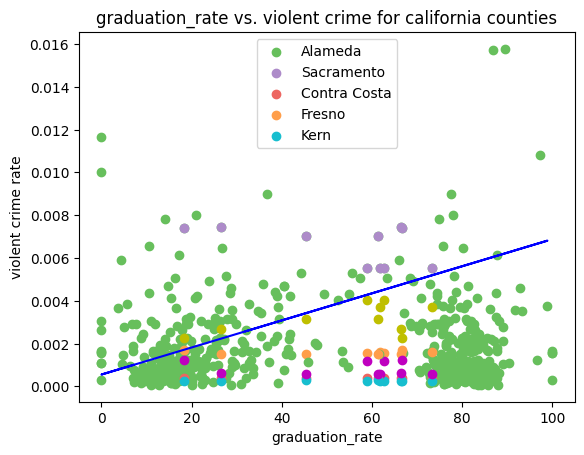

In [54]:
# was trying to graph the significant rates for counties that have similar populations
# as sf and la to do the county comparison that daisy wanted

significant_violent_crime = ['od_deaths', 'graduation_rate', 'median_household_income', 'percent_urban']
sf_pop_bucket = ["Alameda", "Sacramento", "Contra Costa", "Fresno", "Kern"]
colors = ['#ED6661', '#FF9E4A', '#17BECF', 'm', 'y']

for stat in significant_violent_crime:
    plot_rates(clean_data[f'{stat}'], clean_data.violent_crime_rate, 
               f'{stat}' + " vs. violent crime for california counties",
              f'{stat}', "violent crime rate", '#67BF5C')
    sf_data = clean_data[clean_data.county == 'San Francisco']
    plt.scatter(sf_data[stat], sf_data.violent_crime_rate, color='#AD8BC9')
    i = 0
    for county in sf_pop_bucket:
        color = colors[i]
        cty_data = clean_data[clean_data.county == f'{county}']
        plt.scatter(sf_data[stat], cty_data.violent_crime_rate, color=color)
        i+=1
    a, b = np.polyfit(clean_data[stat], clean_data.violent_crime_rate, 1)
    plt.plot(clean_data[stat], a * clean_data[stat] + b, color='b')
    plt.legend(sf_pop_bucket)
    
significant_property_crime = ['population', 'graduation_rate', 'median_household_income', 'percent_urban']

## Regression

In [16]:
clean_data.median_household_income = clean_data.median_household_income.astype(float)

In [18]:
regression_formula = "1 + population + republican + unemployment + health_factors + median_household_income + health_outcomes + od_deaths + graduation_rate + free_reduced_meals + percent_urban + C(year)"
fit = smf.ols(
    f"violent_crime_rate ~ {regression_formula}",
    clean_data,
).fit(cov_type="HC1")
res = res_to_df(fit).set_index("name")

Crime difference attributable to 90th vs 10th percentile: 0.3182727188311149


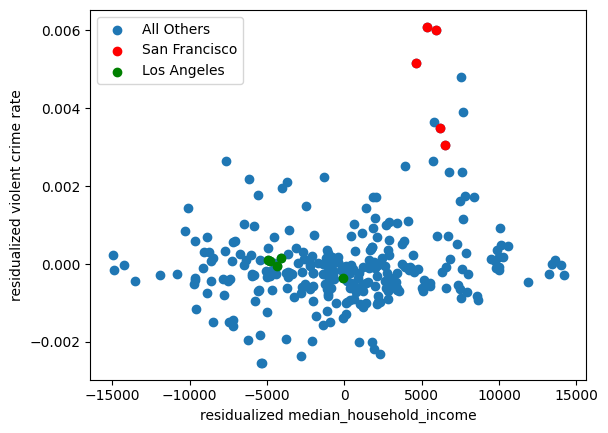

In [35]:
# general code for getting residualized fit from any variable to crime
IV = 'median_household_income'
residual_crime_fit = smf.ols(
    f"violent_crime_rate ~ {''.join(regression_formula.split(IV))}",
    clean_data,
).fit(cov_type="HC1")

residual_IV_fit = smf.ols(
    f"{IV} ~ {''.join(regression_formula.split(IV))}",
    clean_data,
).fit(cov_type="HC1")

IV_effect = pd.DataFrame()
IV_effect['crime_residuals'] = clean_data.violent_crime_rate - residual_crime_fit.predict(clean_data)
IV_effect['IV_residuals'] = clean_data[IV] - residual_IV_fit.predict(clean_data)
plt.scatter(IV_effect.IV_residuals, IV_effect.crime_residuals)

sf_index = clean_data[clean_data.county == 'San Francisco'].index
la_index = clean_data[clean_data.county == 'Los Angeles'].index
plt.scatter(IV_effect.loc[sf_index, 'IV_residuals'], IV_effect.loc[sf_index, 'crime_residuals'], color='r')
plt.scatter(IV_effect.loc[la_index, 'IV_residuals'], IV_effect.loc[la_index, 'crime_residuals'], color='g')
plt.ylabel('residualized violent crime rate')
plt.xlabel(f'residualized {IV}')
plt.legend(['All Others', 'San Francisco', 'Los Angeles'])

# take the difference between 10th and 90th percentile, multiply it by coefficient
stats = IV_effect.describe([0.1,0.9])
x = res["coeff"].loc[IV] * (stats.IV_residuals.loc['90%'] - stats.IV_residuals.loc['10%'])

# percent of violent_crime difference attributed to income
print(f"Crime difference attributable to 90th vs 10th percentile: {x / clean_data.violent_crime_rate.mean()}")